## First lesson practice with custom data

### 1. import packages

In [39]:
# https://pypi.org/project/duckduckgo-search/
try:
  from duckduckgo_search import DDGS
except:
  ! pip install -q duckduckgo_search
  from duckduckgo_search import DDGS

In [3]:
# https://fastcore.fast.ai/
from fastcore.all import *

In [5]:
# https://fastdownload.fast.ai/core.html
from fastdownload import download_url

# 2. Download images of birds and non-birds

In [47]:
# Define a function to search for image using duckduckgo and return L (fastcore List)
'''
"""DuckDuckGo images search. Query params: https://duckduckgo.com/params

Args:
    keywords: keywords for query.
    region: wt-wt, us-en, uk-en, ru-ru, etc. Defaults to "wt-wt".
    safesearch: on, moderate, off. Defaults to "moderate".
    timelimit: Day, Week, Month, Year. Defaults to None.
    size: Small, Medium, Large, Wallpaper. Defaults to None.
    color: color, Monochrome, Red, Orange, Yellow, Green, Blue,
        Purple, Pink, Brown, Black, Gray, Teal, White. Defaults to None.
    type_image: photo, clipart, gif, transparent, line.
        Defaults to None.
    layout: Square, Tall, Wide. Defaults to None.
    license_image: any (All Creative Commons), Public (PublicDomain),
        Share (Free to Share and Use), ShareCommercially (Free to Share and Use Commercially),
        Modify (Free to Modify, Share, and Use), ModifyCommercially (Free to Modify, Share, and
        Use Commercially). Defaults to None.
    max_results: max number of results. If None, returns results only from the first response. Defaults to None.

Yields:
    dict with image search results.

"""
'''
def search_images(term, max_images=30):
  with DDGS() as ddgs:
    keywords = term
    ddgs_images_gen = ddgs.images(keywords=keywords,
                                  max_results=max_images)
    results = L(ddgs_images_gen).itemgot('image')

  return results

In [48]:
urls = search_images('bird photos', max_images=5)
urls[0]

'https://images.alphacoders.com/492/492674.jpg'

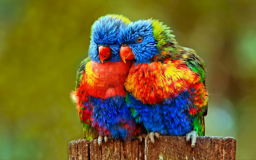

In [49]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

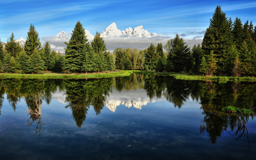

In [50]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

In [51]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
  dest = (path/o)
  dest.mkdir(exist_ok=True, parents=True)
  download_images(dest, urls=search_images(f'{o} photo'))
  sleep(10)  # Pause between searches to avoid over-loading server
  download_images(dest, urls=search_images(f'{o} sun photo'))
  sleep(10)
  download_images(dest, urls=search_images(f'{o} shade photo'))
  sleep(10)
  resize_images(path/o, max_size=400, dest=path/o)

In [52]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

4

### 3. Prepare dataloader and Train model

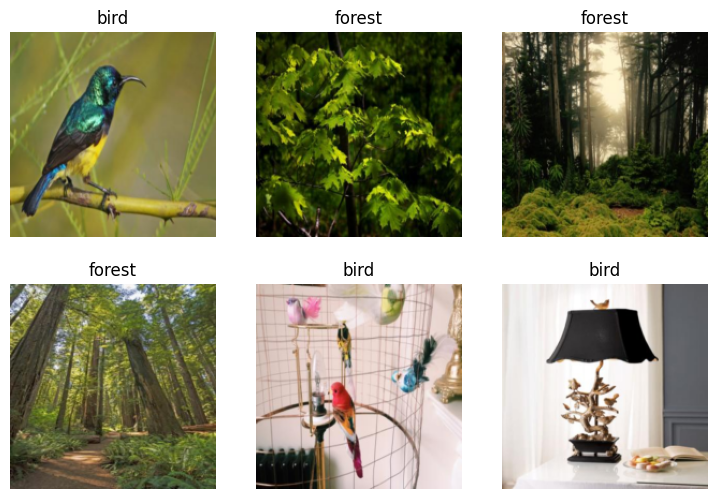

In [53]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [56]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 61.2MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.605122,0.946592,0.300000,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.235787,0.160249,0.133333,00:01
1,0.143178,0.041494,0.033333,00:00
2,0.104886,0.041453,0.033333,00:00


In [57]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000
